In [2203]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

import tensorflow as tf
print(tf.__version__)

1.15.0


In [2204]:
epochs=600
batch_size=100

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

select_features=True

SCALE_TARGET = True
SCALE_FEATURES = True

RUN_MODEL = True


In [2205]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [2206]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [2207]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,1.00,1.00,1.00,2.50,0.15,0.24
1,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.00,1.00,1.00,1.89,0.15,0.24
2,0.07,0.03,0.02,0.03,0.02,0.01,0.01,0.44,0.20,1.00,1.00,1.00,1.00,1.00,1.00,1.35,0.15,0.24
3,0.07,0.03,0.02,0.02,0.02,0.01,0.01,0.23,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.26,0.13,0.24
4,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.24,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.36,0.24


In [2208]:
data.shape

(6766, 18)

# clear noice from outliers

In [2209]:
df = data

In [2210]:
df.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
count,"6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00"
mean,0.83,0.21,0.02,0.20,0.12,0.05,0.03,0.53,1.83,2.76,2.76,2.76,2.76,2.76,2.76,4.10,5.03,2.97
std,0.62,0.13,0.00,0.13,0.08,0.04,0.01,0.58,1.99,1.10,1.09,1.09,1.09,1.09,1.09,2.08,4.20,3.51
min,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.50,1.00,1.00,1.00,1.00,1.00,1.10,0.00,0.02
25%,0.19,0.08,0.02,0.05,0.03,0.04,0.02,0.12,0.02,2.00,2.00,2.00,2.00,2.00,2.00,1.92,0.49,0.24
50%,0.84,0.22,0.02,0.20,0.12,0.05,0.03,0.32,1.15,3.00,3.00,3.00,3.00,3.00,3.00,4.21,5.14,0.49
75%,1.29,0.30,0.02,0.30,0.18,0.06,0.04,0.58,3.28,4.00,4.00,4.00,4.00,4.00,4.00,5.78,8.20,5.81
max,2.73,0.91,0.04,0.64,0.34,0.63,0.10,2.53,6.58,4.00,4.00,4.00,4.00,4.00,4.00,9.66,20.13,9.75


shape before (6766, 18)
latency quantiles min 9.65 max 0.24
shape after (4233, 18)


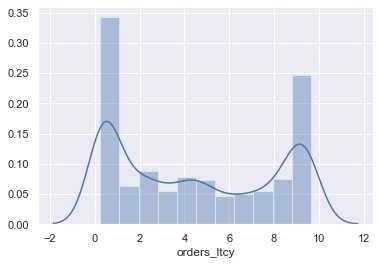

In [2211]:
df = data
print('shape before {}'.format(df.shape))
if 1 == 1:
    minq = df['orders_ltcy'].quantile(0.3)
    maxq = df['orders_ltcy'].quantile(0.99)
    print('latency quantiles min {} max {}'.format(maxq, minq))
    df = df[df['orders_ltcy'] > minq]
    df = df[df['orders_ltcy'] < maxq]
    sns.distplot(df['orders_ltcy'])
print('shape after {}'.format(df.shape)) 

In [2212]:
data = df
data.shape

(4233, 18)

# Shuffle the data

In [2213]:
# shuffle the data
from sklearn.utils import shuffle
data = shuffle(data, random_state=0)
print('shape {}'.format(data.shape))
data.head(5)

shape (4233, 18)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
5616,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,1.18
2380,1.34,0.26,0.01,0.35,0.19,0.02,0.02,0.99,0.17,2.00,2.00,2.00,2.00,2.00,2.00,3.80,10.42,8.89
2693,1.37,0.37,0.02,0.39,0.22,0.04,0.02,1.10,1.86,2.00,2.00,2.00,2.00,2.00,2.00,4.76,9.07,8.91
2532,1.48,0.25,0.02,0.31,0.21,0.03,0.02,1.08,1.24,2.00,2.00,2.00,2.00,2.00,2.00,4.50,10.31,9.22
1052,0.08,0.08,0.01,0.03,0.02,0.03,0.02,0.07,0.18,2.00,2.00,2.00,2.00,2.00,2.00,1.26,0.33,0.28


In [2214]:
x_data = data.drop(['orders_ltcy'], axis=1)
x_data = x_data.values
print("Shape x_data: ", x_data.shape)
print("type x_data: ", type(x_data))

y_data = data['orders_ltcy'].values
y_data = y_data.reshape(-1,1)
print("Shape y_data: ", y_data.shape)
print("type y_data: ", type(y_data))

num_data = len(x_data)
print("There are {} sample data".format(num_data))

Shape x_data:  (4233, 17)
type x_data:  <class 'numpy.ndarray'>
Shape y_data:  (4233, 1)
type y_data:  <class 'numpy.ndarray'>
There are 4233 sample data


In [2215]:
x_dataset = np.expand_dims(x_data, axis=2)
n_depth = x_dataset.shape[1]
n_width = x_dataset.shape[2]
x_dataset.shape

(4233, 17, 1)

In [2216]:
y_dataset = y_data.reshape(y_data.shape[0])
n_targets = y_data.shape[1]
y_dataset.shape

(4233,)

In [2217]:

print('Experiment has {} number of features and {} number of target(s)'.format(n_depth,n_targets))


Experiment has 17 number of features and 1 number of target(s)


In [2218]:
validate_split = 0.1
test_split = 0.1
train_split = 1 - (test_split + validate_split)

num_data = len(x_dataset)

num_test = int(test_split * num_data)
num_validate = int(validate_split * num_data)
num_train = num_data - (num_test + num_validate)
print('Data splitted to training {} , validation {} and testing {}'.format(num_train, num_validate, num_test))

Data splitted to training 3387 , validation 423 and testing 423


In [2219]:
x_train = x_dataset[:num_train]
x_validate = x_dataset[num_train:num_train+num_validate]
x_test = x_dataset[num_train+num_validate:]

print("x_train {} , x_validate {} , x_test {}".format(x_train.shape, x_validate.shape, x_test.shape))

len(x_train) + len(x_validate) + len(x_test)

x_train (3387, 17, 1) , x_validate (423, 17, 1) , x_test (423, 17, 1)


4233

In [2220]:
y_train = y_dataset[:num_train]
y_validate = y_dataset[num_train:num_train+num_validate]
y_test = y_dataset[num_train+num_validate:]

print("y_train {} , y_validate {} , y_test {}".format(y_train.shape, y_validate.shape, y_test.shape))

len(y_train) + len(y_validate) + len(y_test)

y_train (3387,) , y_validate (423,) , y_test (423,)


4233

# Scaling

In [2221]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if SCALE_FEATURES:
    x_scaler = StandardScaler()  # StandardScaler() or MinMaxScaler()
    
    dim_z, dim_x, dim_y = x_train.shape[0], x_train.shape[1], x_train.shape[2]
    x_train = x_train.reshape(dim_z, dim_x)    
    x_train = x_scaler.fit_transform(x_train)
    x_train = x_train.reshape(dim_z, dim_x, dim_y)
    
    dim_z, dim_x, dim_y = x_test.shape[0], x_test.shape[1], x_test.shape[2]
    x_test = x_test.reshape(dim_z, dim_x)    
    x_test = x_scaler.transform(x_test)
    x_test = x_test.reshape(dim_z, dim_x, dim_y)

In [2222]:
if SCALE_TARGET:
    y_scaler =  MinMaxScaler() # StandardScaler() or MinMaxScaler()
    
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_train = y_scaler.fit_transform(y_train)
    y_train = y_train.reshape(y_train.shape[0])
    
    y_test = y_test.reshape(y_test.shape[0], 1)
    y_test = y_scaler.transform(y_test)
    y_test = y_test.reshape(y_test.shape[0])

In [2223]:
print('y_test shape {}'.format(y_test.shape))
y_test[0:10]

y_test shape (423,)


array([3.70088322e-01, 4.85823833e-01, 3.90433411e-04, 7.11863875e-01,
       4.37919221e-01, 4.11883360e-01, 6.24903231e-01, 1.36652440e-01,
       4.24017403e-01, 9.91483625e-01])

In [2224]:
# data batch generator
def batch_generator(batch_size, sequence_length=n_depth, n_features=n_width):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, n_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        #y_shape = (batch_size, sequence_length, num_y_signals)
        #y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        y_batch = []

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx]
            y_batch.append(y_train[idx])
        
        yield (x_batch, np.array(y_batch))

In [2225]:
generator = batch_generator(batch_size)

In [2226]:
# test the batch generator
if 1 == 1:
    x_batch, y_batch = next(generator)
    print(x_batch.shape)
    print(y_batch.shape)

(100, 17, 1)
(100,)


In [2227]:
# test and validate tuples
test_data = (x_test, y_test)
validate_data = (x_validate, y_validate)

In [2228]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import RMSprop, Adam
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2229]:
# 1-D CONV CNN for feature recognition
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=4, kernel_initializer='normal', activation='relu', input_shape=(n_depth,n_width)))
model.add(Conv1D(filters=8, kernel_size=4, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(n_targets, kernel_initializer='normal', activation='linear'))

adam = Adam(lr=learning_rate, decay=decay)
# or loss= 'mean_absolute_percentage_error'
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_159 (Conv1D)          (None, 14, 8)             40        
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 11, 8)             264       
_________________________________________________________________
dropout_83 (Dropout)         (None, 11, 8)             0         
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 5, 8)              0         
_________________________________________________________________
flatten_80 (Flatten)         (None, 40)                0         
_________________________________________________________________
dense_313 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_314 (Dense)            (None, 10)                210       
__________

In [2230]:
# call backs
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
path_model = models_dir + 'best_mlp_model.h5'
mc = ModelCheckpoint(path_model
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

In [2231]:
%%time
steps_per_epoch = math.ceil(num_train / batch_size)   # = total number of training data points divided by the batch size
print('steps_per_epoch {}'.format(steps_per_epoch))

if RUN_MODEL:
    history = model.fit_generator(generator=generator, epochs=epochs
                                  , steps_per_epoch=steps_per_epoch
                                  , validation_data=validate_data
                                  , callbacks=callbacks, verbose=1, shuffle=False)
    #history = model.fit(x_train, y_train, epochs=epochs
                        #, verbose=1,callbacks=callbacks,shuffle=True,validation_data=validate_data)
    
    

Epoch 1/600
34/34 [==============================] - 14s 399ms/step - loss: 0.3166 - mean_squared_error: 0.3166 - val_loss: 30.3172 - val_mean_squared_error: 30.3172

Epoch 00001: val_loss improved from inf to 30.31718, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/600
34/34 [==============================] - 0s 14ms/step - loss: 0.1796 - mean_squared_error: 0.1796 - val_loss: 25.9290 - val_mean_squared_error: 25.9290

Epoch 00002: val_loss improved from 30.31718 to 25.92901, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/600
34/34 [==============================] - 0s 13ms/step - loss: 0.1363 - mean_squared_error: 0.1363 - val_loss: 25.7868 - val_mean_squared_error: 25.7868

Epoch 00003: val_loss improved from 25.92901 to 25.78675, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 4/600
34/34 [==================

Epoch 31/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 25.0429 - val_mean_squared_error: 25.0429

Epoch 00031: val_loss improved from 25.19864 to 25.04292, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 32/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 25.0679 - val_mean_squared_error: 25.0679

Epoch 00032: val_loss did not improve from 25.04292
Epoch 33/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0861 - mean_squared_error: 0.0861 - val_loss: 24.9521 - val_mean_squared_error: 24.9521

Epoch 00033: val_loss improved from 25.04292 to 24.95209, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 34/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 25.1348 - val

34/34 [==============================] - 1s 15ms/step - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 24.4593 - val_mean_squared_error: 24.4593

Epoch 00064: val_loss improved from 24.52180 to 24.45931, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 65/600
34/34 [==============================] - 1s 15ms/step - loss: 0.0787 - mean_squared_error: 0.0787 - val_loss: 24.6433 - val_mean_squared_error: 24.6433

Epoch 00065: val_loss did not improve from 24.45931
Epoch 66/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0789 - mean_squared_error: 0.0789 - val_loss: 24.5116 - val_mean_squared_error: 24.5116

Epoch 00066: val_loss did not improve from 24.45931
Epoch 67/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0777 - mean_squared_error: 0.0777 - val_loss: 24.6239 - val_mean_squared_error: 24.6239

Epoch 00067: val_loss did not improve from 24.45931
Epoch 68/600
34/34 [================


Epoch 00099: val_loss improved from 24.37368 to 24.36680, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 100/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 24.5608 - val_mean_squared_error: 24.5608

Epoch 00100: val_loss did not improve from 24.36680
Epoch 101/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0713 - mean_squared_error: 0.0713 - val_loss: 24.4187 - val_mean_squared_error: 24.4187

Epoch 00101: val_loss did not improve from 24.36680
Epoch 102/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0739 - mean_squared_error: 0.0739 - val_loss: 24.5132 - val_mean_squared_error: 24.5132

Epoch 00102: val_loss did not improve from 24.36680
Epoch 103/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0710 - mean_squared_error: 0.0710 - val_loss: 24.4253 - val_mean_squared_error: 24.4253

Epoch 00103: val_l

34/34 [==============================] - 0s 15ms/step - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 24.2886 - val_mean_squared_error: 24.2886

Epoch 00135: val_loss did not improve from 24.12528
Epoch 136/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 24.4194 - val_mean_squared_error: 24.4194

Epoch 00136: val_loss did not improve from 24.12528
Epoch 137/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 24.2000 - val_mean_squared_error: 24.2000

Epoch 00137: val_loss did not improve from 24.12528
Epoch 138/600
34/34 [==============================] - 0s 15ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 24.1609 - val_mean_squared_error: 24.1609

Epoch 00138: val_loss did not improve from 24.12528
Epoch 139/600
34/34 [==============================] - 0s 15ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 23.9734 - val_

34/34 [==============================] - 1s 16ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 24.2284 - val_mean_squared_error: 24.2284

Epoch 00172: val_loss did not improve from 23.97337
Epoch 173/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 24.2867 - val_mean_squared_error: 24.2867

Epoch 00173: val_loss did not improve from 23.97337
Epoch 174/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 24.1714 - val_mean_squared_error: 24.1714

Epoch 00174: val_loss did not improve from 23.97337
Epoch 175/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 24.0801 - val_mean_squared_error: 24.0801

Epoch 00175: val_loss did not improve from 23.97337
Epoch 176/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 24.1313 - val_


Epoch 00207: val_loss did not improve from 23.87845
Epoch 208/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 24.0261 - val_mean_squared_error: 24.0261

Epoch 00208: val_loss did not improve from 23.87845
Epoch 209/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 24.0342 - val_mean_squared_error: 24.0342

Epoch 00209: val_loss did not improve from 23.87845
Epoch 210/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 24.0904 - val_mean_squared_error: 24.0904

Epoch 00210: val_loss did not improve from 23.87845
Epoch 211/600
34/34 [==============================] - 0s 15ms/step - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 24.1136 - val_mean_squared_error: 24.1136

Epoch 00211: val_loss did not improve from 23.87845
Epoch 212/600
34/34 [==============================] - 0s 14ms/step - l

34/34 [==============================] - 0s 14ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 23.8671 - val_mean_squared_error: 23.8671

Epoch 00245: val_loss improved from 23.87845 to 23.86714, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 246/600
34/34 [==============================] - 1s 15ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 23.8431 - val_mean_squared_error: 23.8431

Epoch 00246: val_loss improved from 23.86714 to 23.84315, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 247/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 23.8170 - val_mean_squared_error: 23.8170

Epoch 00247: val_loss improved from 23.84315 to 23.81701, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 248/600
34/34 [=====================

34/34 [==============================] - 0s 14ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 23.8909 - val_mean_squared_error: 23.8909

Epoch 00281: val_loss did not improve from 23.81701
Epoch 282/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - val_loss: 24.0209 - val_mean_squared_error: 24.0209

Epoch 00282: val_loss did not improve from 23.81701
Epoch 283/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 24.0091 - val_mean_squared_error: 24.0091

Epoch 00283: val_loss did not improve from 23.81701
Epoch 284/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 24.1110 - val_mean_squared_error: 24.1110

Epoch 00284: val_loss did not improve from 23.81701
Epoch 285/600
34/34 [==============================] - 1s 15ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 23.9240 - val_

34/34 [==============================] - 0s 14ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 24.0105 - val_mean_squared_error: 24.0105

Epoch 00318: val_loss did not improve from 23.81701
Epoch 319/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 23.9928 - val_mean_squared_error: 23.9928

Epoch 00319: val_loss did not improve from 23.81701
Epoch 320/600
34/34 [==============================] - 0s 13ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 23.9830 - val_mean_squared_error: 23.9830

Epoch 00320: val_loss did not improve from 23.81701
Epoch 321/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 23.9568 - val_mean_squared_error: 23.9568

Epoch 00321: val_loss did not improve from 23.81701
Epoch 322/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 23.9325 - val_

34/34 [==============================] - 0s 14ms/step - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 23.9032 - val_mean_squared_error: 23.9032

Epoch 00355: val_loss did not improve from 23.80080
Epoch 356/600
34/34 [==============================] - 0s 15ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 23.9357 - val_mean_squared_error: 23.9357

Epoch 00356: val_loss did not improve from 23.80080
Epoch 357/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 23.9036 - val_mean_squared_error: 23.9036

Epoch 00357: val_loss did not improve from 23.80080
Epoch 358/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 23.9571 - val_mean_squared_error: 23.9571

Epoch 00358: val_loss did not improve from 23.80080
Epoch 359/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 24.0646 - val_

34/34 [==============================] - 0s 14ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - val_loss: 23.8916 - val_mean_squared_error: 23.8916

Epoch 00392: val_loss did not improve from 23.80080
Epoch 393/600
34/34 [==============================] - 1s 15ms/step - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 23.9504 - val_mean_squared_error: 23.9504

Epoch 00393: val_loss did not improve from 23.80080
Epoch 394/600
34/34 [==============================] - 1s 16ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 23.8841 - val_mean_squared_error: 23.8841

Epoch 00394: val_loss did not improve from 23.80080
Epoch 395/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 23.9344 - val_mean_squared_error: 23.9344

Epoch 00395: val_loss did not improve from 23.80080
Epoch 396/600
34/34 [==============================] - 0s 14ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 24.0146 - val_

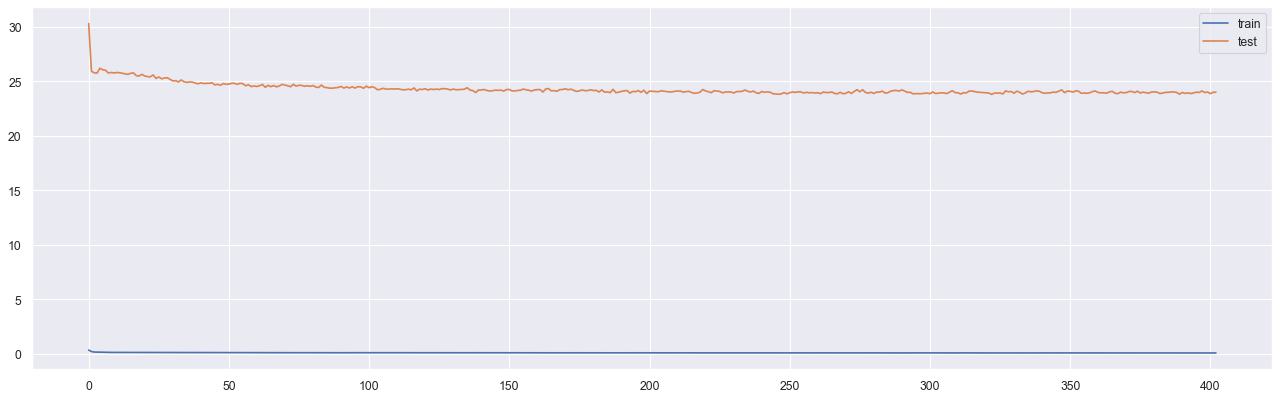

In [2232]:
# plot history
if RUN_MODEL:
    plt.figure(figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [2233]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 24.30  std: (0.56)


In [2234]:
# Load the best saved model
try:
    model = models.load_model(path_model)
except Exception as error:
    print("Error trying to load model.")
    print(error)
    

# Plot Prediction

In [2235]:
def y_comparison(start_idx, length=100, target_scaled=SCALE_TARGET, data_set='train'):
    """
    Obtain predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if data_set == 'train':
        # Use training-data.
        x = x_train
        y_true = y_train
    elif data_set == 'validate':
        x = x_validate
        y_true = y_validate
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    #x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    if target_scaled:
        # The output of the model is scaled.
        # Do an inverse map to get it back to the scale
        # of the original data-set.
        y_pred = y_scaler.inverse_transform(y_pred)
    
    y_pred = y_pred.reshape(y_pred.shape[0])
    print("shape y_pred: %", y_pred.shape)
    print("shape y_true: %", y_true.shape)
    
    return y_true, y_pred


#This helper-function plots the predicted and true output-signals.
def plot_comparison(signal_true, signal_pred):
    """
    Plot the predicted and true output-signals.
    """

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
    # Plot labels etc.
    plt.ylabel('ltcy')
    plt.legend()
    plt.show()

# Check on Some Training Data

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [2236]:
print("total number of training targets {}".format(num_train))
train_true, train_pred = y_comparison(start_idx=0, length=num_train, data_set='train')


total number of training targets 3387
shape y_pred: % (3387,)
shape y_true: % (3387,)


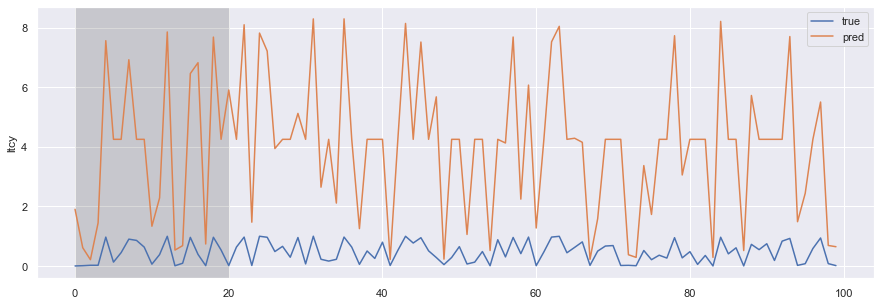

In [2237]:
plot_comparison(train_true[10:110], train_pred[10:110])

In [2238]:
import math
# calculate RMSE
mse = math.sqrt(mean_squared_error(train_true, train_pred))
print('Train MSE: %.3f' % mse)

Train MSE: 3.946


<function matplotlib.pyplot.show(*args, **kw)>

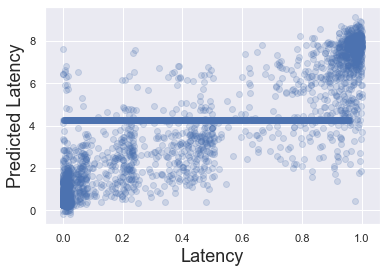

In [2239]:
plt.scatter(train_true, train_pred, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

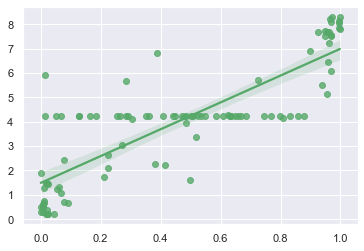

In [2240]:
ax = sns.regplot(x=train_true[10:110], y=train_pred[10:110], color='g')

In [2241]:
r2_train = metrics.r2_score(train_true, train_pred)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = -111.39366216598354


# Evaluate Model

In [2242]:
print("total number of testing targets {}".format(num_test))
test_true, test_pred = y_comparison(start_idx=0, length=num_test, data_set='test')


total number of testing targets 423
shape y_pred: % (423,)
shape y_true: % (423,)


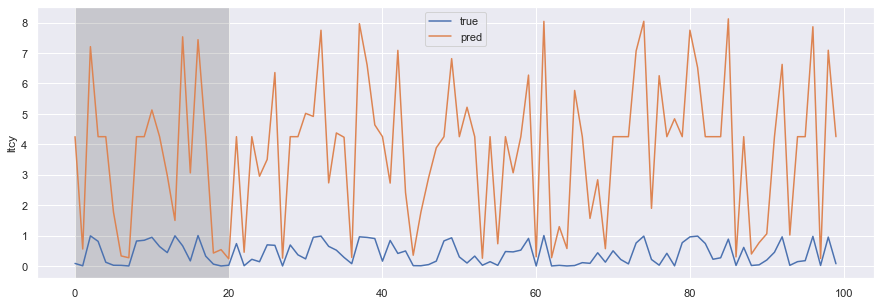

In [2243]:
plot_comparison(test_true[10:110], test_pred[10:110])

# *** R2

In [2244]:
r2_test = metrics.r2_score(test_true[10:110], test_pred[10:110])
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = -118.11963636381486


Text(0.5, 1.0, 'Residual PDF')

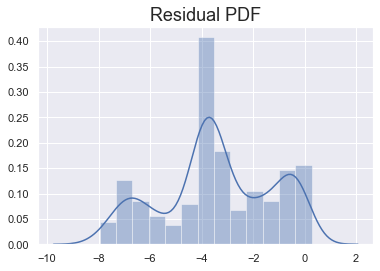

In [2245]:
sns.distplot(test_true - test_pred)
plt.title('Residual PDF', size=18)

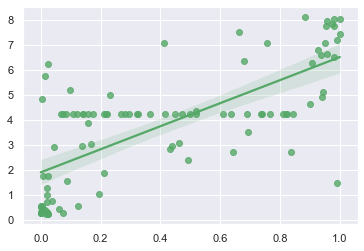

In [2246]:
ax = sns.regplot(x=test_true[10:110], y=test_pred[10:110], color='g')

<function matplotlib.pyplot.show(*args, **kw)>

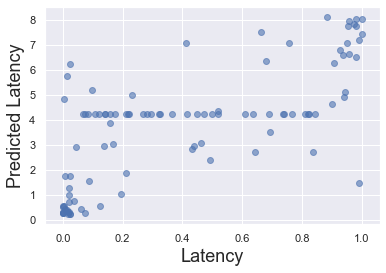

In [2247]:
plt.scatter(test_true[10:110], test_pred[10:110], alpha=0.6)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [2248]:
print('shape y test {}'.format(test_true.shape))
print('shape y predicted {}'.format(test_pred.shape))

#print ("Actual test values: \n {}".format(test_signal_true[:20]))
#print ("Predicted test values: \n {}".format(test_signal_pred[:20]))

print("")
# calculate RMSE
mse = math.sqrt(mean_squared_error(test_true, test_pred))
print('Test MSE: %.3f' % mse)

shape y test (423,)
shape y predicted (423,)

Test MSE: 4.023


In [2249]:
true_df = round(pd.DataFrame(test_true, columns=['actual']),2)
pred_df = round(pd.DataFrame(test_pred, columns=['predicted']),2)


compare_df = pd.concat([true_df,pred_df], axis=1, sort=False)

# testing mean_absolute_percentage_error
compare_df['residual'] = round(compare_df['actual'] - compare_df['predicted'], 2)
compare_df['difference%'] = round(np.absolute(compare_df['residual']* 100 / compare_df['actual']),2)

compare_df.head(5)

,actual,predicted,residual,difference%
0,0.37,4.25,-3.88,"1,048.65"
1,0.49,3.28,-2.79,569.39
2,0.00,0.36,-0.36,inf
3,0.71,4.25,-3.54,498.59
4,0.44,4.48,-4.04,918.18


In [2250]:
compare_df.describe()

,actual,predicted,residual,difference%
count,423.00,423.00,423.00,423.00
mean,0.47,3.88,-3.42,inf
std,0.37,2.41,2.12,nan
min,0.00,0.20,-7.95,20.69
25%,0.08,1.77,-4.21,585.48
50%,0.44,4.25,-3.61,785.42
75%,0.88,4.70,-1.65,"2,083.61"
max,1.00,8.95,0.27,inf


In [2251]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
compare_df.sort_values(by = ['difference%'])

,actual,predicted,residual,difference%
178,0.29,0.35,-0.06,20.69
334,0.99,0.72,0.27,27.27
23,0.99,1.50,-0.51,51.52
320,0.94,1.51,-0.57,60.64
110,0.16,0.37,-0.21,131.25
240,0.74,1.90,-1.16,156.76
51,0.84,2.72,-1.88,223.81
162,0.99,3.21,-2.22,224.24
253,1.00,3.38,-2.38,238.00
282,0.67,2.31,-1.64,244.78


In [2252]:
print("... FINISH ....")

... FINISH ....
